# 모듈 임포트

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
from glob import glob

# 폴더경로 가져오기

In [2]:
normal_path = "기계시설물고장예지/current/2.2kW/L-SF-04/정상"
abnormal_path = "기계시설물고장예지/current/2.2kW/L-SF-04/베어링불량"

# 폴더 내 csv파일 추출

In [3]:
# 정상
normal_files = []
filelist = sorted(glob(f'{normal_path}/*.csv')) 
for file in filelist:
    normal_files.append(file)
print(len(normal_files))

# 비정상
abnormal_files = []
filelist = sorted(glob(f'{abnormal_path}/*.csv')) 
for file in filelist:
    abnormal_files.append(file)
print(len(abnormal_files))

77
200


# 데이터 전처리

In [4]:
# 정상
normal_list_of_df = [pd.read_csv(file,    # 파일명 설정
                 encoding='utf-8',                                      # csv 파일 인코딩 방식 설정
                 header=None,                                           # 헤더 없음 설정
                 names=['Time', 'R', 'S', 'T', 'e'],                    # 열 이름 설정
                 skiprows=9) for file in normal_files]

# 비정상
abnormal_list_of_df = [pd.read_csv(file,    # 파일명 설정
                 encoding='utf-8',                                      # csv 파일 인코딩 방식 설정
                 header=None,                                           # 헤더 없음 설정
                 names=['Time', 'R', 'S', 'T', 'e'],                    # 열 이름 설정
                 skiprows=9) for file in abnormal_files]

In [5]:
# 정상
normal_df_list = []
for i in normal_list_of_df:
    df = i.drop('e', axis=1)                                          
    df1 = df.set_index('Time')
    normal_df_list.append(df1)

# 비정상
abnormal_df_list = []
for i in abnormal_list_of_df:
    df = i.drop('e', axis=1)                                          
    df1 = df.set_index('Time')
    abnormal_df_list.append(df1)
    
print(len(normal_df_list))
print(len(abnormal_df_list))


77
200


# 전처리된 데이터를 하나로 합침

In [6]:
# 정상 concat
normal_concat = pd.concat(normal_df_list)
print(normal_concat.shape)
# 비정상 concat
abnormal_concat = pd.concat(abnormal_df_list)
print(abnormal_concat.shape)

(154000, 3)
(400000, 3)


# 데이터 이미지화(정상)

In [11]:
# 정상
normal_value = normal_concat.values
print(normal_value.shape)
nv = np.array(np.vsplit(normal_value, 3080))
print(nv.shape)


(154000, 3)
(3080, 50, 3)


In [12]:
arr = []
for value in nv:
    gaf = GramianAngularField(method='summation')
    X_gaf = gaf.fit_transform(value.T)
    arr.append(X_gaf.T)

    
normal_X = np.array(arr)
print(normal_X.shape)

(3080, 50, 50, 3)


# 데이터 이미지화(비정상)

In [14]:
abnormal_value = abnormal_concat.values
anv = np.vsplit(abnormal_value, 8000)
a = len(anv)
b = len(anv[0])
c = len(anv[0][0])
print(a,b,c)

8000 50 3


In [15]:
arr = []
for value in anv:
    gaf = GramianAngularField(method='summation')
    X_gaf = gaf.fit_transform(value.T)
    arr.append(X_gaf.T)

abnormal_X = np.array(arr)
print(abnormal_X.shape)

(8000, 50, 50, 3)


# 데이터 라벨링

In [16]:
# 라벨링, 정상: 0, 비정상: 1
normal_Y = np.zeros((normal_X.shape[0], 1))
abnormal_Y = np.ones((abnormal_X.shape[0], 1))

print(normal_Y.shape)
print(abnormal_Y.shape)

# X, Y 끼리 concatenate
X = np.concatenate((normal_X,abnormal_X))
Y = np.concatenate((normal_Y,abnormal_Y))
print(X.shape)
print(Y.shape)

(3080, 1)
(8000, 1)
(11080, 50, 50, 3)
(11080, 1)


# 훈련 세트 설정

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, stratify=Y, random_state=50)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.2, shuffle=True, stratify=y_test, random_state=50)

print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(7756, 50, 50, 3)
(2659, 50, 50, 3)
(665, 50, 50, 3)
(7756, 1)
(2659, 1)
(665, 1)


# 정규화

In [18]:
# 정규화
x_train = (x_train - np.min(x_train)) / (np.max(x_train)- np.min(x_train))
x_test = (x_test - np.min(x_test)) / (np.max(x_test)- np.min(x_test))
x_val = (x_val - np.min(x_val)) / (np.max(x_val)- np.min(x_val))

print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(7756, 50, 50, 3)
(2659, 50, 50, 3)
(665, 50, 50, 3)


# 학습에 필요한 모듈 임포트

In [19]:
import tensorflow as tf
plt.style.use('seaborn-white')
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2022-03-03 11:55:03.604393: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [20]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# 모델구성

In [21]:
model = Sequential() 
model.add(Conv2D(32, (3,3), input_shape=(50,50,3), activation='relu', padding='same'))        
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='loss', mode='min', patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)


2022-03-03 11:55:05.478737: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-03-03 11:55:05.522835: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-03-03 11:55:05.522910: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-03 11:55:05.525578: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-03-03 11:55:05.525697: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-03-03 11:55:05.526538: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcu

# 모델 학습

In [22]:
history = model.fit(x_train, y_train, epochs=1000, validation_data=(x_val, y_val), batch_size = 32, callbacks=[early_stopping, mc])

2022-03-03 11:55:06.459274: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-03 11:55:06.478723: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 4099895000 Hz


Epoch 1/1000


2022-03-03 11:55:06.792238: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-03-03 11:55:07.337475: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2022-03-03 11:55:08.122211: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-03 11:55:08.122248: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2022-03-03 11:55:08.123163: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-03 11:55:08.123235: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-03-03 11:55:08.133512: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully ope

243/243 [==============================] - 4s 5ms/step - loss: 0.5669 - accuracy: 0.7198 - val_loss: 0.5136 - val_accuracy: 0.7188
Epoch 2/1000
243/243 [==============================] - 1s 4ms/step - loss: 0.4236 - accuracy: 0.8000 - val_loss: 0.3149 - val_accuracy: 0.8692
Epoch 3/1000
243/243 [==============================] - 1s 4ms/step - loss: 0.2615 - accuracy: 0.8931 - val_loss: 0.1789 - val_accuracy: 0.9248
Epoch 4/1000
243/243 [==============================] - 1s 4ms/step - loss: 0.1521 - accuracy: 0.9442 - val_loss: 0.0934 - val_accuracy: 0.9609
Epoch 5/1000
243/243 [==============================] - 1s 4ms/step - loss: 0.1004 - accuracy: 0.9645 - val_loss: 0.0662 - val_accuracy: 0.9880
Epoch 6/1000
243/243 [==============================] - 1s 4ms/step - loss: 0.0679 - accuracy: 0.9768 - val_loss: 0.0266 - val_accuracy: 0.9955
Epoch 7/1000
243/243 [==============================] - 1s 4ms/step - loss: 0.0529 - accuracy: 0.9831 - val_loss: 0.0181 - val_accuracy: 0.9955
Epoch

243/243 [==============================] - 1s 4ms/step - loss: 0.0059 - accuracy: 0.9981 - val_loss: 7.3108e-04 - val_accuracy: 1.0000
Epoch 58/1000
243/243 [==============================] - 1s 4ms/step - loss: 0.0098 - accuracy: 0.9973 - val_loss: 0.0102 - val_accuracy: 0.9940


# 모델 평가

In [23]:
(test_loss, test_acc) = model.evaluate(x_test,  y_test, verbose=2)
print('\n테스트 정확도:', test_acc)

84/84 - 0s - loss: 0.0045 - accuracy: 0.9985

테스트 정확도: 0.9984956979751587


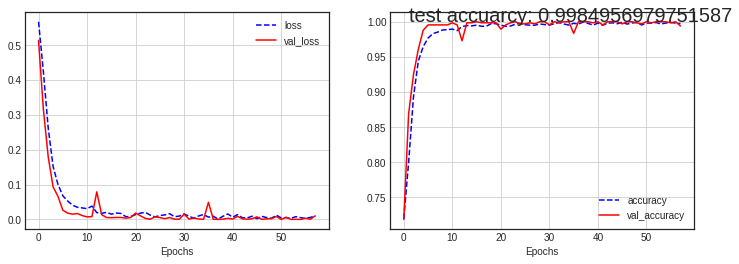

In [24]:
history.history.keys()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b--', label='loss')
plt.plot(history.history['val_loss'], 'r', label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'b--', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r', label='val_accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()
plt.text(1,1,f'test accuarcy: {test_acc}',fontsize=20)


plt.show()

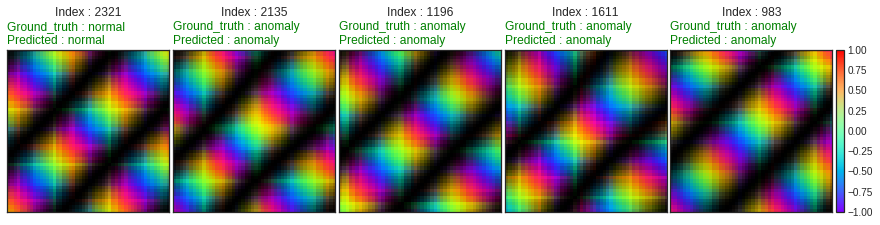

In [25]:
import random

random_list = random.sample(range(y_test.size), 5)

fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111, nrows_ncols=(1,5), axes_pad=0.05, share_all=True, cbar_mode='single')
y_predicted = (model.predict(x_test) > 0.5).astype("int32")

i = 0
for ax, im in zip(grid, [x_test[random_list[0]], x_test[random_list[1]], x_test[random_list[2]], x_test[random_list[3]], x_test[random_list[4]]]):
    ground_truth = 'anomaly' if y_test[random_list[i]][0] == 1.0 else 'normal'
    predicted = 'anomaly' if y_predicted[random_list[i]][0] == 1.0 else 'normal'
    color = 'g' if ground_truth == predicted else 'r'
    ax.set_title(f"Index : {random_list[i]}\n\n", loc='center')
    ax.set_title(f"Ground_truth : {ground_truth}\nPredicted : {predicted}", loc='left', color=color)
    im = ax.imshow(im, cmap='rainbow', origin='lower', vmin=-1., vmax=1.)
    i = i+1
    
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)

plt.show()

In [26]:
yes = []
no = []
y_predicted = (model.predict(x_test) > 0.5).astype("int32")
for i in range(len(y_test)):
    if y_test[i] == y_predicted[i]:
        yes.append(i)
    else:
        no.append(i)

print(f"정답: {len(yes)}개")
print(f"오답: {len(no)}개")

print(f"정답률: {round((len(yes)/len(y_test)),2)}%")
           

정답: 2655개
오답: 4개
정답률: 1.0%
